# Advances in Machine Learning with Big Data

### (part 1 of 2) 
### Trinity 2020 Weeks 1 - 4
### Dr Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

## 3. Data abundance and 'jaggedness' -> the problem of overfit

## 4. Resampling methods, and model selection

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. **Data abundance and its 'jaggedness' -> the problem of overfit**

1. **Resampling methods, and model selection**

1. Regularization through predictor/feature selection (Lasso etc.)

1. Moving from linear regression to the perceptron

1. Moving from linear regression to the random forest (and similar)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np  
import pandas as pd  

In [3]:
#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold

In [4]:
import sbs_sklearn    # module where I've put some functions from the last class

In [5]:
import itertools      # today, we'll use this

### We return to our

### > dataset

### > prediction problem

### > & linear model

**Q.: given the time, date, and complexity of an invoice, what's its expected spend per item shipped?**

In [6]:
# the data:
df, invalids, invoices = sbs_sklearn.get_standard_data()

2020-04-15 15:56:15,882 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-04-15 15:56:18,735 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [7]:
#  We build some additional columns in our dataframe to take logs etc.:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

In [8]:
predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

In [9]:
# set out `y` and `X` variables:
y = invoices.log_item_spend
X = invoices[predictors] 

# we'll do 50-fold studies this time:
n_folds = 50

In [10]:
model = linear_model.LinearRegression()

The linear model fits OK with 50-fold testing



2020-04-15 15:58:59,152 INFO:In study 1/50, train on 20165 points; then test on the other 412: first few test points = [  8  87 158 232 347] 


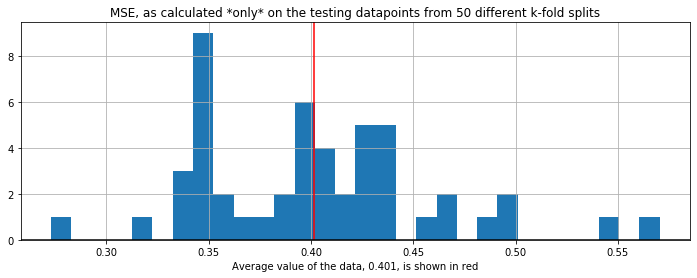

In [11]:
scores = sbs_sklearn.train_n_test(X, y, n_folds, metric=metrics.mean_squared_error)

sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

OK, now lets stress-test the linear model:

2020-04-15 15:58:59,570 INFO:In study 1/50, train on 412 points; then test on the other 20165: first few test points = [0 1 2 3 4] 


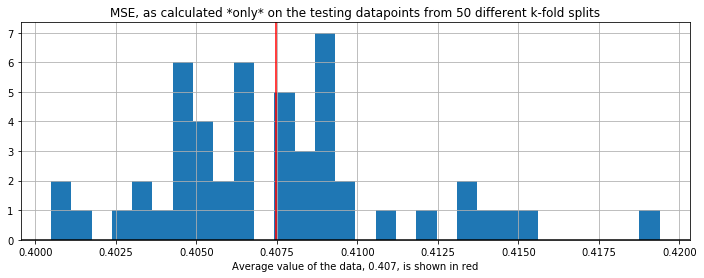

In [12]:
scores = sbs_sklearn.train_n_test(X, y, n_folds, metric=metrics.mean_squared_error, 
                                  train_on_minority=True)   #<< invoke this new option

sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

#### Comments:

* our linear model can be fit on a rather small proportion of our dataset

* I would say that in part, this is because it is fairly simple and concise

* but this simplicity is tantalising: 

     * could we replace the model with a more complicated one, to get a better MSE?


* *Introduction to Statistical Learning* Chapter 3.3.2

#### Polynomial Regression:

**Recall our linear setup**: we have an i.i.d. sequence of observations, $\{(y_i, x_i), i=0, 1, ...\}$ where we are interested in moments of the R.V. $y_i$, conditional on the multivariate R.V.  $x_i$ (of length, say, $p$). 

We *postulate* a linear relationship of the following form:

\begin{equation}
y_i = x_i ' \beta + \epsilon_i,
\end{equation}

where $\beta$ is a vector of parameters of length $p$, and the i.i.d. sequence of random variables $\{\epsilon_i\}$ is independent of the regressors $\{x_i\}$

**Perhaps** we are missing interactions or non-linearities. So, lets try augmenting $x_i$ with all possible cross-terms, 

\begin{equation}
\{x_i x_j : i= 0, 1 , ...; j = 0, 1, ...; i \leq j\},
\end{equation} 

... and we can go up to third, and higher orders, so $x_i x_j x_k$, or ... etc.

In [18]:
def build_polynomial_dataframe(data, order):
    """
    @param data: a DataFrame() of features (or regressors)
    @param order: a positive integer - the highest order of polynomial terms to be generated
    @return: a DataFrame() containing data, as well as polynomial terms of that data, up to order 
    """
    poly_data = data.copy()
    for o in range(1, order + 1):
        for tpl in itertools.combinations_with_replacement(predictors, o):
            name = "_x_".join(tpl)
            poly_data[name] = invoices[list(tpl)].prod(axis=1)
    return poly_data

We'll create polynomials of, say, orders up to 4:

In [14]:
polynomial_X = build_polynomial_dataframe(invoices[predictors], 4)
polynomial_X.shape

(20577, 69)

2020-04-15 15:59:00,282 INFO:In study 1/50, train on 20165 points; then test on the other 412: first few test points = [ 39 103 182 238 251] 


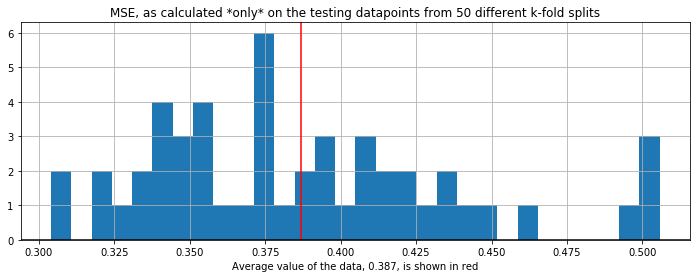

In [15]:
scores = sbs_sklearn.train_n_test(polynomial_X, y, n_folds, metric=metrics.mean_squared_error)

sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

This seems to be helping - MSE has fallen above 0.4

#### However, the added flexibility comes with a risk:

### The 'jaggedness' of a small dataset is instilled into the fit, causing trouble in test data:

2020-04-15 15:59:03,174 INFO:In study 1/50, train on 412 points; then test on the other 20165: first few test points = [0 1 2 3 4] 


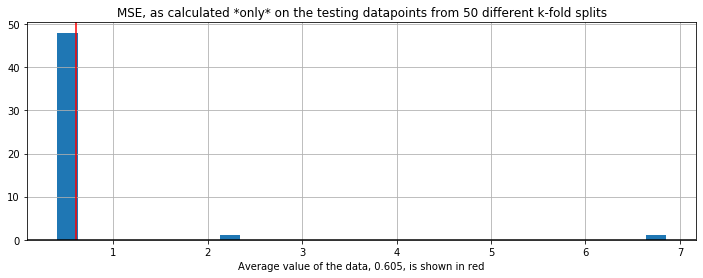

In [16]:
scores = sbs_sklearn.train_n_test(polynomial_X, y, n_folds, metric=metrics.mean_squared_error, 
                                  train_on_minority=True)

sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

* failure on test data
* **overfitting**, or - to put it another way -
* poor **bias/variance tradeoff** (*Introduction to Statistical Learning* 2.2.2)

We fit our model to the specific nature ('jaggedness') of the data which we happen to have at hand

Our modelling fails to **generalise** to new cases

There exists a collection of remedies, falling under the term **Regularization** ([-> Wikipedia](https://en.wikipedia.org/wiki/Regularization_(mathematics)))

